In [123]:
from bayestuner.tuner import BayesTuner
import numpy as np
import seaborn as sns
from bayestuner.optimizer import DifferentialEvolution
from bayestuner.acquisitionfunc import UCB
import matplotlib.pyplot as plt
import math
import matplotlib.animation as animation
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from scipy.optimize import differential_evolution
from sklearn.gaussian_process import GaussianProcessRegressor
%matplotlib notebook

Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [2]:
def optimizer(obj_func, initial_theta, bounds):
    # * 'obj_func' is the objective function to be minimized, which
    #   takes the hyperparameters theta as parameter and an
    #   optional flag eval_gradient, which determines if the
    #   gradient is returned additionally to the function value
    # * 'initial_theta': the initial value for theta, which can be
    #   used by local optimizers
    # * 'bounds': the bounds on the values of theta
    # Returned are the best found hyperparameters theta and
    # the corresponding value of the target function.
    res = differential_evolution(lambda theta: obj_func(theta,eval_gradient = False),bounds)
    theta_opt = res.x
    func_min  = res.fun
    return theta_opt, func_min

In [119]:
f = lambda x : x*np.sin(x)
#f = lambda x : np.sin(10*x)/(2*x) + (x-1)**4

dim = 5
tuner = BayesTuner(objective = f,
                   bounds = [(-0,19,0)],
                   acquisition = lambda i : UCB(i,lambda x : 1.96),
                   n_iter = 30, init_samples = 5)

tuner.gp = GaussianProcessRegressor(kernel = ConstantKernel()*RBF(),
                                    alpha = 1e-2,
                                    n_restarts_optimizer = 3,
                                    optimizer = optimizer,
                                    normalize_y = True).fit(tuner.past_hyper,tuner.past_evals)
tuner.tune()

<IPython.core.display.Javascript object>


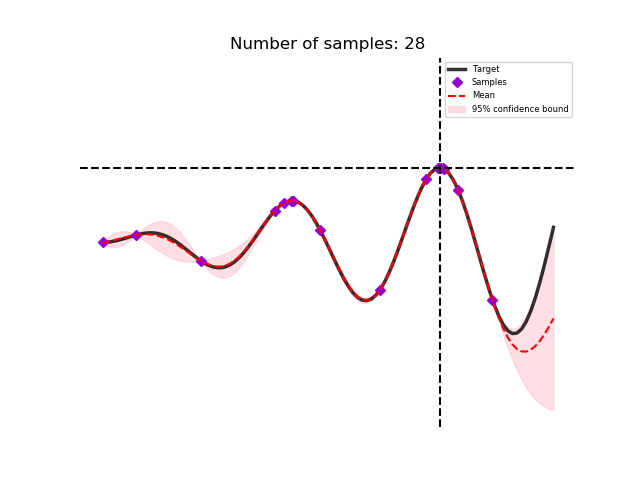

In [139]:
fig, ax = plt.subplots()
x   = np.linspace(0,19,100)


def update(num):
    
    plt.cla()
    plt.ylim(-35,35)
    ax.plot(x,f(x),'k',linewidth = 2.5,alpha = 0.8,label = 'Target')
    ax.plot(tuner.past_hyper[:10+num],tuner.past_evals[:10+num],'D',color = 'darkviolet',markersize = 5,label = 'Samples')
    #ax.plot(tuner.past_hyper[:10+num][-1],tuner.past_evals[:10+num][-1],'X',color = 'red',markersize = 10)
    
    #print(tuner.gps[10+num].predict(x.reshape(100,1)))
    mean,std = tuner.gps[num].predict(x.reshape(100,1),return_std = True)
    #mean     = [y[0] for y in mean]
    ucb      = [m + 1.96*s for (m,s) in zip(mean,std)]
    ucb      = [y[0] for y in ucb]   
    lcb      = [m - 1.96*s for (m,s) in zip(mean,std)]
    lcb      = [y[0] for y in lcb]
    print(len(mean) == len(x))
    ax.plot(x,mean,'r--',linewidth = 1.5,label = 'Mean')
    ax.set_title(f"Number of samples: {len(tuner.past_hyper[:10+num])}")
    ax.fill_between(x,lcb,ucb,alpha = 0.5,color = 'pink',label = '95% confidence bound')
    ax.axvline(tuner.past_hyper[:10+num][-1],color = 'k',linestyle = '--')
    ax.axhline(tuner.past_evals[:10+num][-1],color = 'k',linestyle = '--')
    plt.axis('off')
    plt.legend(prop={'size': 6})

x   = np.linspace(0,19,100) 
number_of_frames = 50
anim = animation.FuncAnimation(fig, update, number_of_frames,repeat = True,interval = 360, blit = True)    

In [86]:
mean,std = tuner.gps[10].predict(x.reshape(100,1),return_std = True)
ucb      = [m + 1.96*s for (m,s) in zip(mean,std)]
lcb      = [m - 1.96*s for (m,s) in zip(mean,std)]
x   = np.linspace(0,20,100)


0.19588974768808756
0.6124300126253059
1.0620492921528069
1.414540282621834
1.6774781018820053
1.8640209670646954
1.9865635907476005
2.0550937514238594
2.0772336773793354
2.0608835663987843
2.018702296171178
1.945444399831607
1.7839336991991026
1.4910191060524152
1.0641746629316264
0.5250813284968977
-0.09454869656833956
-0.7681734240624329
-1.4765129508724364
-2.196913348890701
-2.898202781642307
-3.5416043078922144
-4.082718113600352
-4.472351054341697
-4.658124575013934
-4.603790792157462
-4.311222839434544
-3.7984787475946056
-3.0847947136232854
-2.191207513191345
-1.1387447678665485
0.05814628140922909
1.3838550100373488
2.7846674470336934
4.17887199648432
5.486558355455802
6.634890546945596
7.558904146383873
8.203480221264291
8.525638429180093
8.496501629541617
8.102679252137294
7.347033966432264
6.248979691686861
4.844815817550939
3.189996002115744
1.3699382336871215
-0.5043118753912508
-2.3855232160025355
-4.239523424177911
-6.000798531183972
-7.594409190040051
-8.9460045575989

<IPython.core.display.Javascript object>


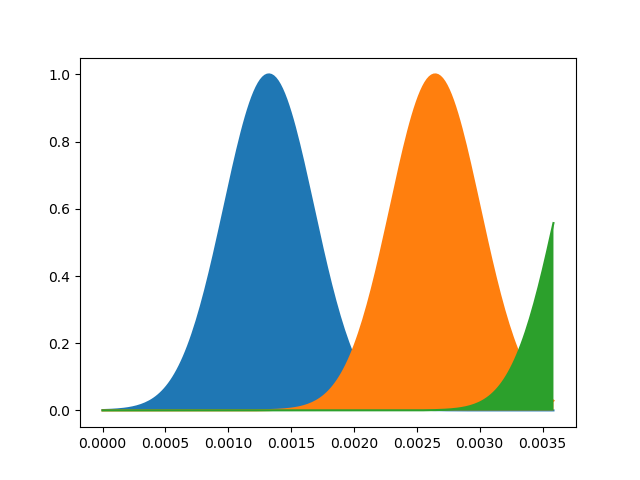

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


Gamma=0.0005
q=1.6e-19
m=0.067*9e-31
B=10
Ec=(1.0567e-34)*B/m

fig, ax = plt.subplots()

n = 3 #number of lines
x = np.arange(0, 3.6e-3, 1.7e-5)        # x-array, third number is interval here, x is energy
lines = [ax.plot(x, np.e**(-(x-((1.0567e-34)*1*1/m))**2/Gamma**2), zorder=i+3)[0] for i in range(n)]
fills = [ax.fill_between(x,0,(np.e**(-(x-((1.0567e-34)*1*1/m))**2/Gamma**2)), facecolor=lines[i].get_color(), zorder=i+3) for i in range(n)]


def animate(i):
    for d, line in enumerate(lines):
        p=(d+1)/2.
        line.set_ydata(np.e**((-(x-((1.0567e-34)*p*i/m))**2)/Gamma**2))
        fills[d].remove()
        fills[d] = ax.fill_between(x,0,(np.e**(-(x-((1.0567e-34)*p*i/m))**2/Gamma**2)), facecolor=lines[d].get_color(), zorder=d+3)# update the data

    return lines + fills


#Init only required for blitting to give a clean slate.
def init():
    for line in lines:
        line.set_ydata(np.ma.array(x, mask=True))
    return lines

ani = animation.FuncAnimation(fig, animate, np.arange(0, 2.5, .01), init_func=init,
    interval=10, blit=True)
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)
#
#ani.save('QHanimati.mp4', writer=writer)

plt.show()
